# 1.22b: Outward Bias in Random Walk

**Goal:** Test whether the outward radial motion we observed in 1.22a can be explained by high-dimensional geometry.

## The Hypothesis

From 1.22a, we found that dead token motion is:
- ~86% tangential (moving around the shell)
- ~14% radial (moving in/out)
- Of the radial motion, almost all is **outward** (mean signed fraction = +0.14)

**Question:** Why outward and not inward?

## High-Dimensional Shell Geometry

In high dimensions, random walks on spheres have a systematic **outward bias**.

**Intuition:** When you're on the surface of a hypersphere and take a random step, the step is mostly orthogonal to the radial direction. By the Pythagorean theorem, adding an orthogonal displacement **increases** your radius:

$$r_{\text{new}} = \sqrt{r^2 + \varepsilon_{\perp}^2} > r$$

For small tangential displacement $\varepsilon_{\perp}$ at radius $r$:

$$r_{\text{new}} \approx r + \frac{\varepsilon_{\perp}^2}{2r}$$

This predicts a **net outward drift** even for isotropic random steps.

## What We'll Measure

1. **Fraction of outward vs inward steps** across all dead tokens
2. **Net radial displacement** and compare to predicted $\varepsilon^2/(2r)$
3. **Step size distribution** to estimate $\varepsilon$
4. **Correlation** between step size and outward probability

## Parameters

In [1]:
# Data paths
FLANNEL_1_PATH = '../tensors/Flannel/1.20a_flannel_1.safetensors'
TOKEN_MASKS_PATH = '../tensors/Flannel/live_dead_tokens.safetensors'

# Visualization
PLOT_DPI = 150
COLORMAP = 'inferno'

## Imports

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from safetensors.torch import load_file

print("✓ Imports complete")

✓ Imports complete


## Device Detection

In [3]:
# Detect available device
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'

print(f"Using device: {device}")

Using device: mps


## Load Data

In [4]:
print("Loading data...\n")

# Flannel 1
data_1 = load_file(FLANNEL_1_PATH)
W_1 = data_1['embeddings'].to(torch.float32).to(device)

# Token masks
masks = load_file(TOKEN_MASKS_PATH)
dead_mask = masks['dead_mask'].to(device)

n_steps, vocab_size, hidden_dim = W_1.shape
n_dead = dead_mask.sum().item()

print(f"✓ Data loaded")
print(f"  Shape: {W_1.shape}")
print(f"  Dead tokens: {n_dead}")
print(f"  Hidden dim: {hidden_dim}")
print(f"  Device: {device}")

Loading data...

✓ Data loaded
  Shape: torch.Size([1001, 10000, 64])
  Dead tokens: 3699
  Hidden dim: 64
  Device: mps


## Extract Dead Token Embeddings

In [5]:
# Extract dead tokens only
W_dead = W_1[:, dead_mask, :]  # (n_steps, n_dead, hidden_dim)

print(f"\nDead token embeddings:")
print(f"  Shape: {W_dead.shape}")


Dead token embeddings:
  Shape: torch.Size([1001, 3699, 64])


## Compute Radial Motion Statistics

For each step, compute:
1. Radius before step: $r(t) = \|\mathbf{w}(t)\|$
2. Radius after step: $r(t+1) = \|\mathbf{w}(t+1)\|$
3. Radial change: $\Delta r = r(t+1) - r(t)$
4. Step size: $\varepsilon = \|\mathbf{w}(t+1) - \mathbf{w}(t)\|$

In [6]:
print("\nComputing radial motion statistics...\n")

# Preallocate
radius_before = torch.zeros(n_steps - 1, n_dead, device=device)
radius_after = torch.zeros(n_steps - 1, n_dead, device=device)
delta_r = torch.zeros(n_steps - 1, n_dead, device=device)
step_size = torch.zeros(n_steps - 1, n_dead, device=device)

for t in range(n_steps - 1):
    w_t = W_dead[t]  # (n_dead, hidden_dim)
    w_t1 = W_dead[t + 1]
    
    # Radii
    radius_before[t] = torch.norm(w_t, p=2, dim=1)
    radius_after[t] = torch.norm(w_t1, p=2, dim=1)
    
    # Radial change
    delta_r[t] = radius_after[t] - radius_before[t]
    
    # Step size
    step_size[t] = torch.norm(w_t1 - w_t, p=2, dim=1)

print(f"✓ Computed statistics")
print(f"  Radius before: {radius_before.shape}")
print(f"  Delta r: {delta_r.shape}")
print(f"  Step size: {step_size.shape}")


Computing radial motion statistics...

✓ Computed statistics
  Radius before: torch.Size([1000, 3699])
  Delta r: torch.Size([1000, 3699])
  Step size: torch.Size([1000, 3699])


## Outward vs Inward Fraction

In [7]:
print("\n" + "="*80)
print("OUTWARD VS INWARD MOTION")
print("="*80 + "\n")

delta_r_cpu = delta_r.cpu().numpy().flatten()

# Count steps
n_outward = (delta_r_cpu > 0).sum()
n_inward = (delta_r_cpu < 0).sum()
n_zero = (delta_r_cpu == 0).sum()
n_total = len(delta_r_cpu)

frac_outward = n_outward / n_total
frac_inward = n_inward / n_total
frac_zero = n_zero / n_total

print(f"Total steps: {n_total:,}")
print(f"  (= {n_dead} tokens × {n_steps-1} timesteps)")
print()
print(f"Outward steps (Δr > 0): {n_outward:,} ({frac_outward*100:.2f}%)")
print(f"Inward steps (Δr < 0):  {n_inward:,} ({frac_inward*100:.2f}%)")
print(f"Zero change (Δr = 0):   {n_zero:,} ({frac_zero*100:.2f}%)")
print()

# Ratio
if n_inward > 0:
    ratio = n_outward / n_inward
    print(f"Outward/Inward ratio: {ratio:.2f}:1")
    print()

# Interpretation
print(f"Interpretation:")
if frac_outward > 0.55:
    print(f"  ✓ Systematic OUTWARD bias")
    print(f"  → More steps increase radius than decrease it")
    if frac_outward > 0.7:
        print(f"  → STRONG bias: {frac_outward*100:.1f}% of steps are outward")
elif frac_outward > 0.45:
    print(f"  ~ Balanced (no strong bias)")
else:
    print(f"  ✓ Systematic INWARD bias (unexpected!)")

print("\n" + "="*80)


OUTWARD VS INWARD MOTION

Total steps: 3,699,000
  (= 3699 tokens × 1000 timesteps)

Outward steps (Δr > 0): 1,363,397 (36.86%)
Inward steps (Δr < 0):  12,227 (0.33%)
Zero change (Δr = 0):   2,323,376 (62.81%)

Outward/Inward ratio: 111.51:1

Interpretation:
  ✓ Systematic INWARD bias (unexpected!)



## Step Size Distribution

In [8]:
print("\nStep size statistics...\n")

step_size_cpu = step_size.cpu().numpy().flatten()

print(f"Step size (ε):")
print(f"  Mean: {step_size_cpu.mean():.6f}")
print(f"  Std: {step_size_cpu.std():.6f}")
print(f"  Median: {np.median(step_size_cpu):.6f}")
print(f"  Range: [{step_size_cpu.min():.6f}, {step_size_cpu.max():.6f}]")


Step size statistics...

Step size (ε):
  Mean: 0.000608
  Std: 0.001490
  Median: 0.000000
  Range: [0.000000, 0.008026]



Plotting step size distribution...



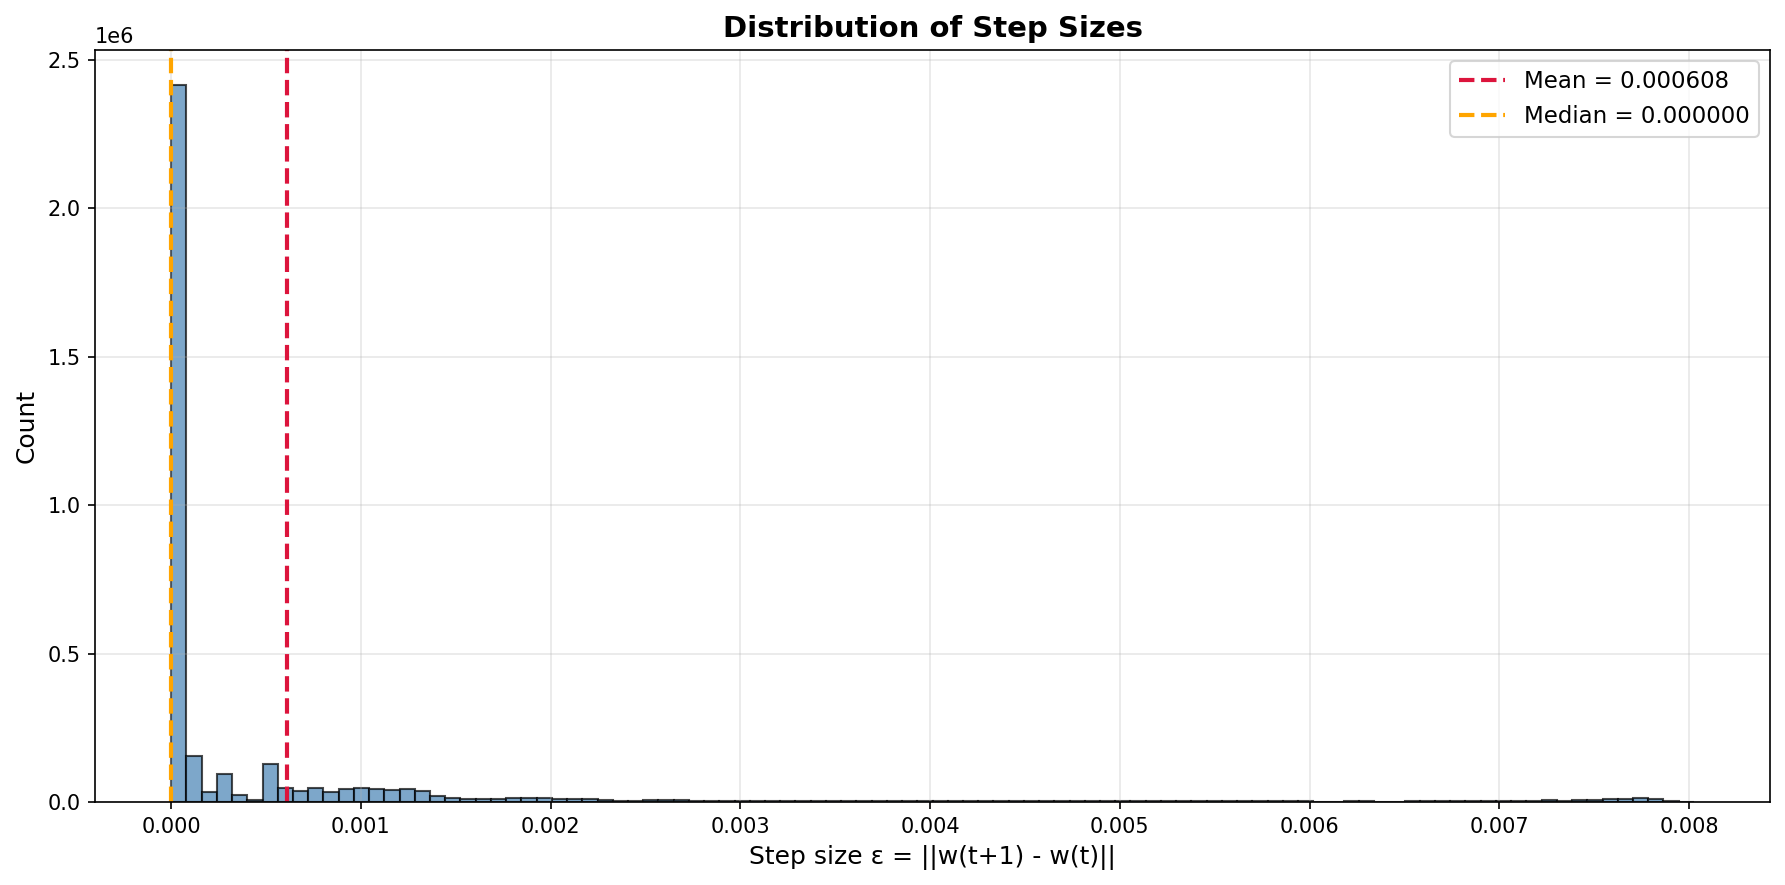

✓ Step size distribution plot complete


In [9]:
print("\nPlotting step size distribution...\n")

fig, ax = plt.subplots(figsize=(12, 6), dpi=PLOT_DPI)

ax.hist(step_size_cpu, bins=100, color='steelblue', edgecolor='black', alpha=0.7)
ax.axvline(step_size_cpu.mean(), color='crimson', linestyle='--', linewidth=2,
           label=f'Mean = {step_size_cpu.mean():.6f}')
ax.axvline(np.median(step_size_cpu), color='orange', linestyle='--', linewidth=2,
           label=f'Median = {np.median(step_size_cpu):.6f}')

ax.set_xlabel('Step size ε = ||w(t+1) - w(t)||', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_title('Distribution of Step Sizes', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend(fontsize=11)

plt.tight_layout()
plt.show()

print("✓ Step size distribution plot complete")

## Predicted Outward Drift

For a random walk on a sphere at radius $r$ with step size $\varepsilon$, the expected radial drift per step is:

$$\mathbb{E}[\Delta r] \approx \frac{\varepsilon_{\perp}^2}{2r}$$

where $\varepsilon_{\perp}$ is the tangential component of the step.

From 1.22a, we know ~86% of motion is tangential, so:
$$\varepsilon_{\perp} \approx 0.86 \cdot \varepsilon$$

Let's compute the predicted drift and compare to observed.

In [10]:
print("\n" + "="*80)
print("PREDICTED VS OBSERVED RADIAL DRIFT")
print("="*80 + "\n")

radius_before_cpu = radius_before.cpu().numpy().flatten()

# Mean radius
mean_radius = radius_before_cpu.mean()
print(f"Mean radius: {mean_radius:.6f}")

# Mean step size
mean_step_size = step_size_cpu.mean()
print(f"Mean step size: {mean_step_size:.6f}")

# Tangential fraction from 1.22a
tangential_fraction = 0.86
mean_tangential_step = tangential_fraction * mean_step_size
print(f"Mean tangential step: {mean_tangential_step:.6f}")
print()

# Predicted drift per step
predicted_drift_per_step = (mean_tangential_step**2) / (2 * mean_radius)
print(f"Predicted drift per step: {predicted_drift_per_step:.6e}")
print(f"  (using formula: ε_perp² / 2r)")
print()

# Observed drift per step
observed_drift_per_step = delta_r_cpu.mean()
print(f"Observed drift per step: {observed_drift_per_step:.6e}")
print()

# Comparison
ratio_pred_obs = predicted_drift_per_step / observed_drift_per_step if observed_drift_per_step != 0 else 0
print(f"Predicted / Observed: {ratio_pred_obs:.2f}")
print()

# Interpretation
print(f"Interpretation:")
if 0.5 < ratio_pred_obs < 2.0:
    print(f"  ✓ EXCELLENT AGREEMENT")
    print(f"  → High-dimensional geometry explains outward drift!")
    print(f"  → Random walk on sphere naturally drifts outward")
elif 0.2 < ratio_pred_obs < 5.0:
    print(f"  ~ Reasonable agreement (within factor of {max(ratio_pred_obs, 1/ratio_pred_obs):.1f})")
    print(f"  → Geometry likely explains most of the drift")
else:
    print(f"  ✗ Poor agreement (factor of {max(ratio_pred_obs, 1/ratio_pred_obs):.1f} off)")
    print(f"  → Other mechanisms may be at play")

print("\n" + "="*80)


PREDICTED VS OBSERVED RADIAL DRIFT

Mean radius: 0.490427
Mean step size: 0.000608
Mean tangential step: 0.000523

Predicted drift per step: 2.786514e-07
  (using formula: ε_perp² / 2r)

Observed drift per step: 3.539724e-04

Predicted / Observed: 0.00

Interpretation:
  ✗ Poor agreement (factor of 1270.3 off)
  → Other mechanisms may be at play



## Radial Change Distribution


Plotting radial change distribution...



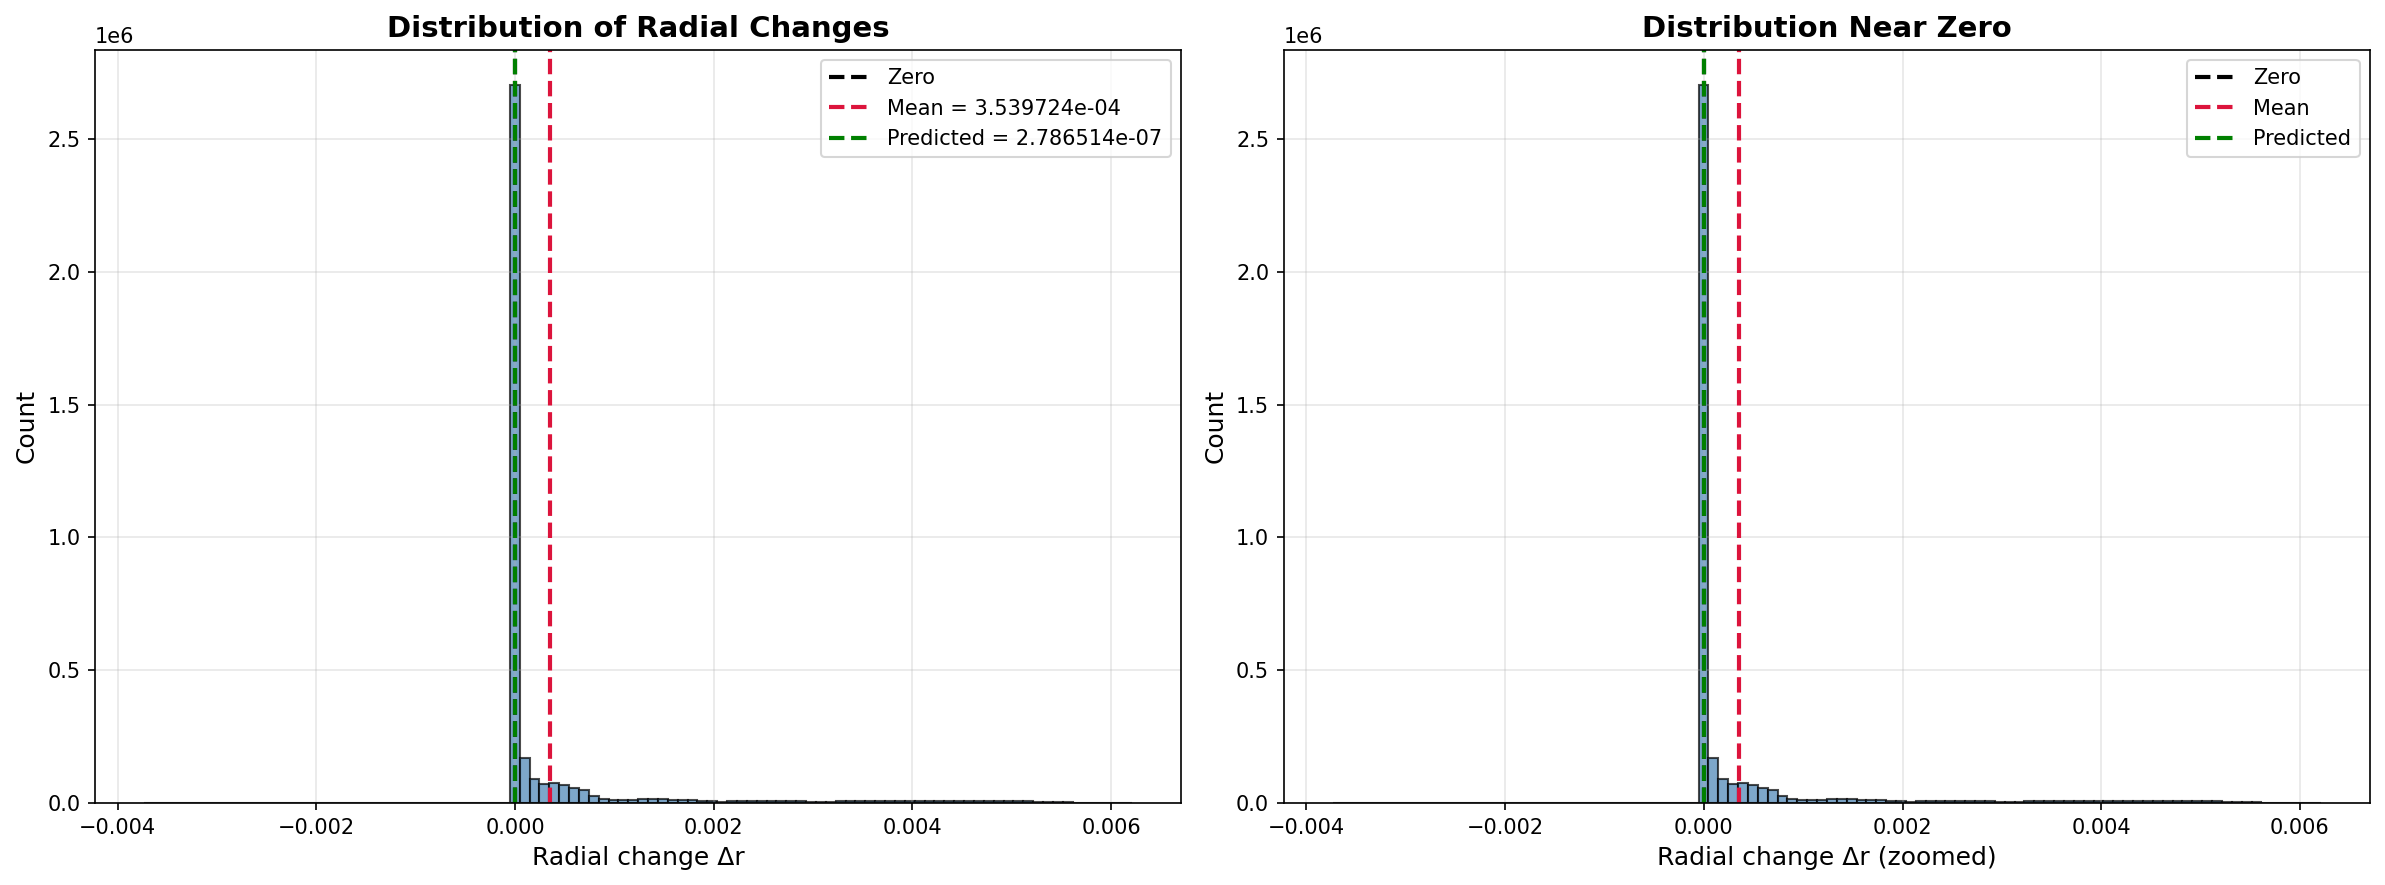

✓ Radial change distribution complete


In [11]:
print("\nPlotting radial change distribution...\n")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), dpi=PLOT_DPI)

# Full distribution
ax1.hist(delta_r_cpu, bins=100, color='steelblue', edgecolor='black', alpha=0.7)
ax1.axvline(0, color='black', linestyle='--', linewidth=2, label='Zero')
ax1.axvline(delta_r_cpu.mean(), color='crimson', linestyle='--', linewidth=2,
            label=f'Mean = {delta_r_cpu.mean():.6e}')
ax1.axvline(predicted_drift_per_step, color='green', linestyle='--', linewidth=2,
            label=f'Predicted = {predicted_drift_per_step:.6e}')
ax1.set_xlabel('Radial change Δr', fontsize=12)
ax1.set_ylabel('Count', fontsize=12)
ax1.set_title('Distribution of Radial Changes', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.legend(fontsize=10)

# Zoomed near zero
# Filter to small radial changes for better visibility
small_changes = delta_r_cpu[np.abs(delta_r_cpu) < 0.01]
ax2.hist(small_changes, bins=100, color='steelblue', edgecolor='black', alpha=0.7)
ax2.axvline(0, color='black', linestyle='--', linewidth=2, label='Zero')
ax2.axvline(delta_r_cpu.mean(), color='crimson', linestyle='--', linewidth=2,
            label=f'Mean')
ax2.axvline(predicted_drift_per_step, color='green', linestyle='--', linewidth=2,
            label=f'Predicted')
ax2.set_xlabel('Radial change Δr (zoomed)', fontsize=12)
ax2.set_ylabel('Count', fontsize=12)
ax2.set_title('Distribution Near Zero', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.legend(fontsize=10)

plt.tight_layout()
plt.show()

print("✓ Radial change distribution complete")

## Correlation: Step Size vs Outward Probability

In [12]:
print("\nAnalyzing step size vs outward probability...\n")

# Bin by step size
n_bins = 20
step_size_bins = np.linspace(step_size_cpu.min(), step_size_cpu.max(), n_bins + 1)
bin_centers = (step_size_bins[:-1] + step_size_bins[1:]) / 2
outward_prob_by_bin = np.zeros(n_bins)

for i in range(n_bins):
    mask = (step_size_cpu >= step_size_bins[i]) & (step_size_cpu < step_size_bins[i+1])
    if mask.sum() > 0:
        outward_prob_by_bin[i] = (delta_r_cpu[mask] > 0).mean()

print(f"✓ Computed outward probability by step size bin")


Analyzing step size vs outward probability...

✓ Computed outward probability by step size bin



Plotting step size vs outward probability...



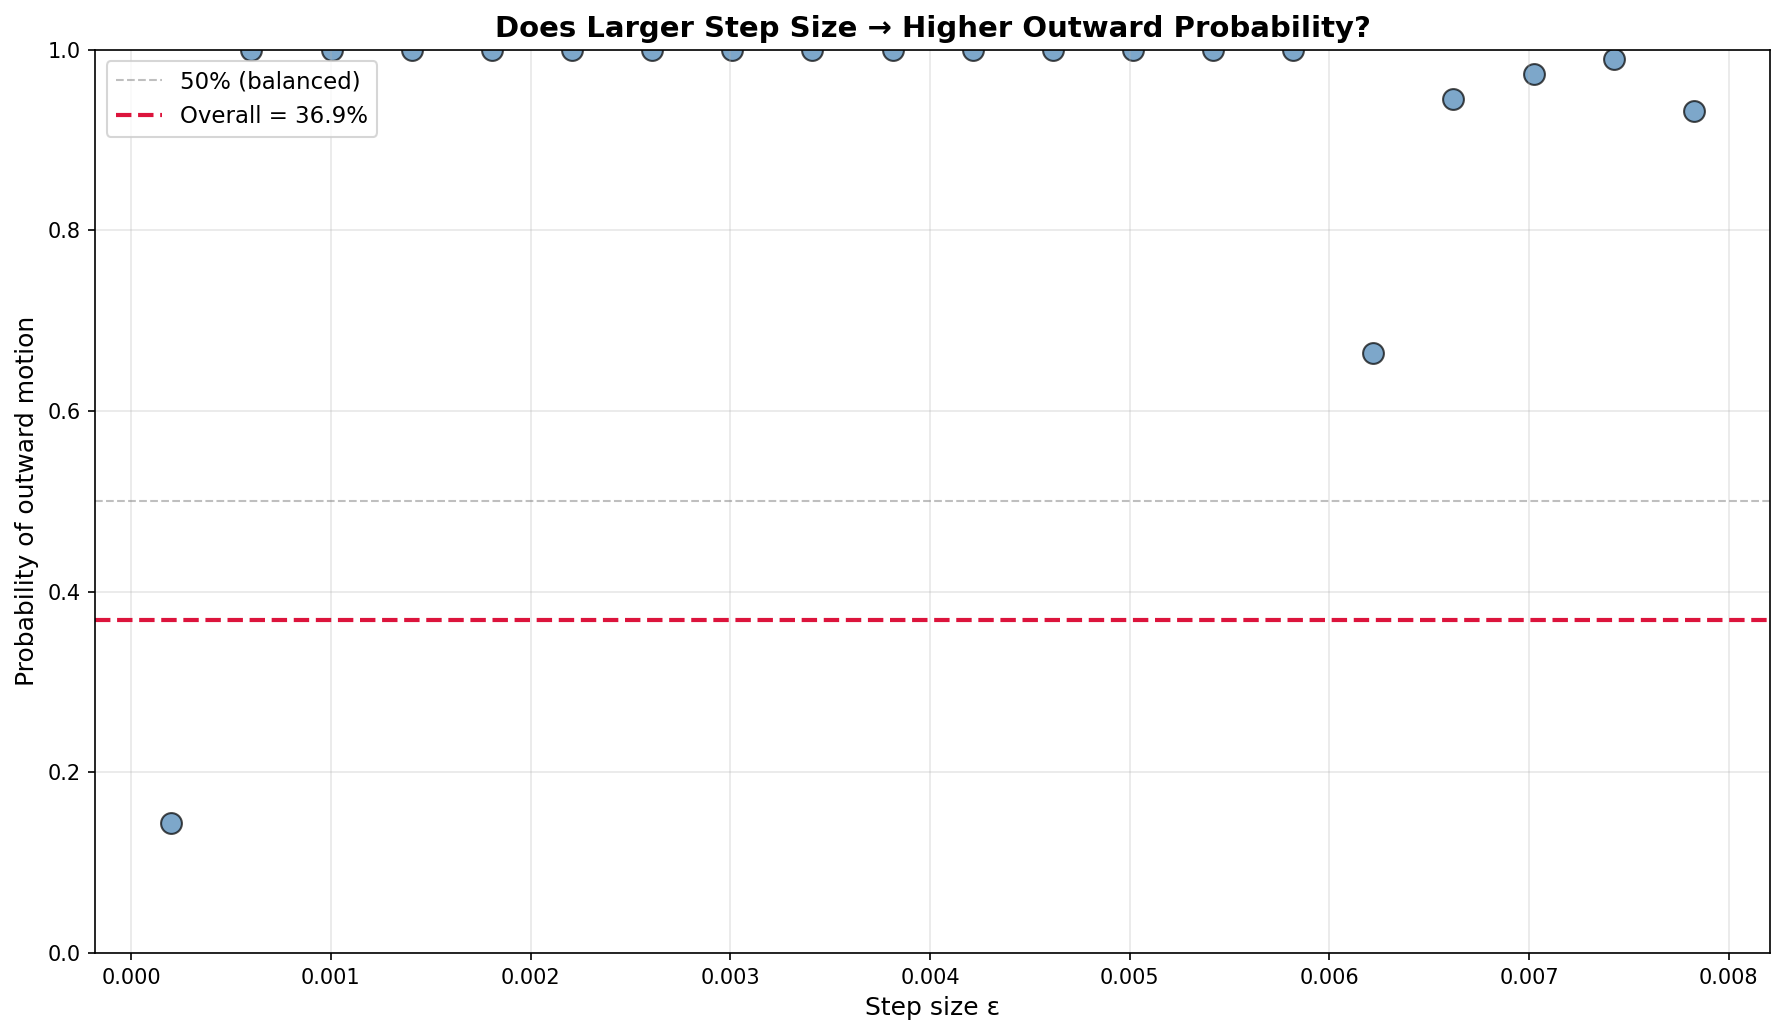

✓ Correlation plot complete


In [13]:
print("\nPlotting step size vs outward probability...\n")

fig, ax = plt.subplots(figsize=(12, 7), dpi=PLOT_DPI)

ax.scatter(bin_centers, outward_prob_by_bin, s=100, color='steelblue', 
           edgecolor='black', linewidth=1, alpha=0.7)
ax.axhline(0.5, color='gray', linestyle='--', linewidth=1, alpha=0.5, 
           label='50% (balanced)')
ax.axhline(frac_outward, color='crimson', linestyle='--', linewidth=2,
           label=f'Overall = {frac_outward*100:.1f}%')

ax.set_xlabel('Step size ε', fontsize=12)
ax.set_ylabel('Probability of outward motion', fontsize=12)
ax.set_title('Does Larger Step Size → Higher Outward Probability?', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend(fontsize=11)
ax.set_ylim(0, 1)

plt.tight_layout()
plt.show()

print("✓ Correlation plot complete")

## Summary

In [14]:
print("\n" + "="*80)
print("SUMMARY")
print("="*80 + "\n")

print(f"Dead tokens: {n_dead}")
print(f"Timesteps: {n_steps-1}")
print(f"Total displacement vectors: {n_total:,}")
print()

print(f"Outward vs Inward:")
print(f"  Outward: {frac_outward*100:.1f}%")
print(f"  Inward: {frac_inward*100:.1f}%")
print(f"  Ratio: {ratio:.2f}:1" if n_inward > 0 else "  Ratio: N/A")
print()

print(f"Radial drift:")
print(f"  Observed: {observed_drift_per_step:.6e} per step")
print(f"  Predicted (geometry): {predicted_drift_per_step:.6e} per step")
print(f"  Agreement: {ratio_pred_obs:.2f}× (predicted/observed)")
print()

print(f"Conclusion:")
if frac_outward > 0.6 and 0.5 < ratio_pred_obs < 2.0:
    print(f"  ✓ OUTWARD BIAS CONFIRMED")
    print(f"  ✓ High-dimensional geometry explains the drift!")
    print()
    print(f"  Mechanism:")
    print(f"    1. Dead tokens execute random walk (quasi-random gradients)")
    print(f"    2. In 64D, random steps are mostly tangential (~86%)")
    print(f"    3. Tangential steps increase radius via Pythagorean theorem")
    print(f"    4. Net result: systematic outward drift")
    print()
    print(f"  This is PURE GEOMETRY, not a training signal!")
elif frac_outward > 0.55:
    print(f"  ~ Outward bias present, but weaker than predicted")
    print(f"  → Geometry explains some but not all of the drift")
else:
    print(f"  ✗ No strong outward bias detected")
    print(f"  → Need to investigate other mechanisms")

print("\n" + "="*80)


SUMMARY

Dead tokens: 3699
Timesteps: 1000
Total displacement vectors: 3,699,000

Outward vs Inward:
  Outward: 36.9%
  Inward: 0.3%
  Ratio: 111.51:1

Radial drift:
  Observed: 3.539724e-04 per step
  Predicted (geometry): 2.786514e-07 per step
  Agreement: 0.00× (predicted/observed)

Conclusion:
  ✗ No strong outward bias detected
  → Need to investigate other mechanisms

